In [2]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import itertools

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

%matplotlib inline

In [5]:
import pandas as pd
import re
from gensim.parsing.preprocessing import *

In [6]:
DATA_PATH = 'corpus.csv'
df = pd.read_csv(DATA_PATH,index_col=0)#, header=None, sep=';',
#                  names=['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 
#                         'tfol', 'tfrien', 'listcount'])
print(df.shape)

(216, 4)


In [9]:
df.head()

,auto,crime,culture,education
0,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p style=""text-...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
1,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><strong><em>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
2,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
3,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p style=""text-..."
4,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."


In [7]:
corpus = []
for topic in df:
    corpus += df[topic].tolist()
    
corpus = pd.Series(corpus)
corpus = corpus.apply(lambda x: x.lower())
corpus = corpus.apply(strip_tags)
corpus = corpus.apply(strip_punctuation2)
corpus = corpus.apply(strip_numeric)
corpus = corpus.apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u' ', x))
corpus = corpus.apply(lambda x: re.sub('«|»', ' ', x))
corpus = corpus.apply(strip_multiple_whitespaces)
corpus = corpus.apply(lambda x: x.partition(' – ')[2])
# corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
corpus.iloc[-1]

'сегодня в городе тольна соберутся победителей ii международного творческого детского фотоконкурса в объятиях природы организаторами масштабного проекта выступают фонд содействия развитию муниципальных образований ассоциация территорий расположения атомных электростанций ао концерн росэнергоатом и венгерская аэс пакш город полярные зори представят виктория серебренникова и екатерина таранникова в течение десяти дней в рамках работы экологического лагеря ребят ждёт увлекательная экскурсионная программа по москве с визитом в экспозиционный центр концерна росэнергоатом и будапеште в тольна российские школьники посетят серию мастер классов от известного профессионального фотохудожника балинта винце берег реки дунай маковые поля рыболовные пруды венгерские деревушки и аэс пакш список мест проведения уроков фотоискусства запланированы и съемки метеоритного дождя итогом экологического лагеря станут не только прекрасные фотографии новые знания приятные впечатления но и дружеские связи между шк

In [31]:
def str_prepr(stringa):
    res_str = stringa.lower()
    res_str = strip_tags(res_str)
    res_str = strip_punctuation2(res_str)
    res_str = strip_numeric(res_str)
    res_str = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u' ', res_str)
    res_str = re.sub('«|»', ' ', res_str)
    res_str = res_str.partition('би порт')[2]
    res_str = re.sub('—|–', ' ', res_str)
    res_str =strip_multiple_whitespaces(res_str)
#     sp = res_str.split()
#     tmp_tokens = []
#     for word in sp:
#         if word not in stop_words.get_stop_words('ru'):
#             if morph.word_is_known(word):
#                 tmp_tokens.append(stemmer.stem(word))
#     res_str = ' '.join(tmp_tokens)
#     res_embedding = vectorizer.transform([res_str])
#     print(res_str)
    return res_str
#     res_str =res_str.partition(' – ')[2]

In [32]:
clear_df = df.apply(lambda x: x.apply(lambda y: str_prepr(y)))

---

## Prepare The Data

In [8]:
import stop_words

In [12]:
vectorizer = TfidfVectorizer(stop_words=stop_words.get_stop_words('ru'))
initial_categories = df.columns.values

In [61]:
clear_df.dropna(inplace=True,axis=0)

(216, 4)

In [69]:
clear_df[clear_df=='']=None

In [88]:
clear_df.dropna(axis=0,inplace=True)

In [92]:
train_x = pd.Series()
train_y = []
test_x = pd.Series()
test_y = []
for col in clear_df.columns:
    index = [col for i in range(clear_df.crime.sample(frac=0.8).shape[0])]
    data = clear_df[col].sample(frac=0.8)
    
    train_y.extend(index)
    train_x = train_x.append(data)
    
    test_y.extend([col for i in range(clear_df[col][~clear_df[col].index.isin(data.index.values)].shape[0])])
    test_x = test_x.append(clear_df[col][~clear_df[col].index.isin(data.index.values)])

In [93]:
X_train = vectorizer.fit_transform(train_x)
X_test = vectorizer.transform(test_x)

print (X_train.shape, X_test.shape)

(572, 16840) (144, 16840)


In [94]:
print (len(train_y), len(test_y))

572 144


---

## Build Models

* **Logistic Regression**
* **SVM**
* **Random Forest**
* **Gradient Boosting Trees**

**Define classifiers:**

In [97]:
y_train = np.array(train_y)
y_test = np.array(test_y)

In [98]:
predictor_lr = LogisticRegression().fit(X_train, y_train)

In [99]:
predictor_svm = LinearSVC().fit(X_train, y_train)

In [100]:
predictor_rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [101]:
predictor_gbt = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

**Evaluate Classifiers:**

In [109]:
y_pred_lr = predictor_lr.predict(X_test)
print ('LR accuracy: {}'.format(round(np.mean(y_test == y_pred_lr), 2)))

LR accuracy: 0.93


In [114]:
y_pred_svm = predictor_svm.predict(X_test)
print ('LR accuracy: {}'.format(round(np.mean(y_test == y_pred_svm), 2)))

LR accuracy: 0.97


In [111]:
y_pred_rf = predictor_rf.predict(X_test)
print ('RF accuracy: {}'.format(round(np.mean(y_test == y_pred_rf), 2)))

RF accuracy: 0.9


In [112]:
y_pred_gbt = predictor_gbt.predict(X_test)
print ('GBT accuracy: {}'.format(round(np.mean(y_test == y_pred_gbt), 2)))

GBT accuracy: 0.88


### [Confusion Matrices](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)


In [117]:
def plot_confusion_matrix(cm, title='Contingency matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    classes = [x.split('.')[-1] for x in initial_categories]
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

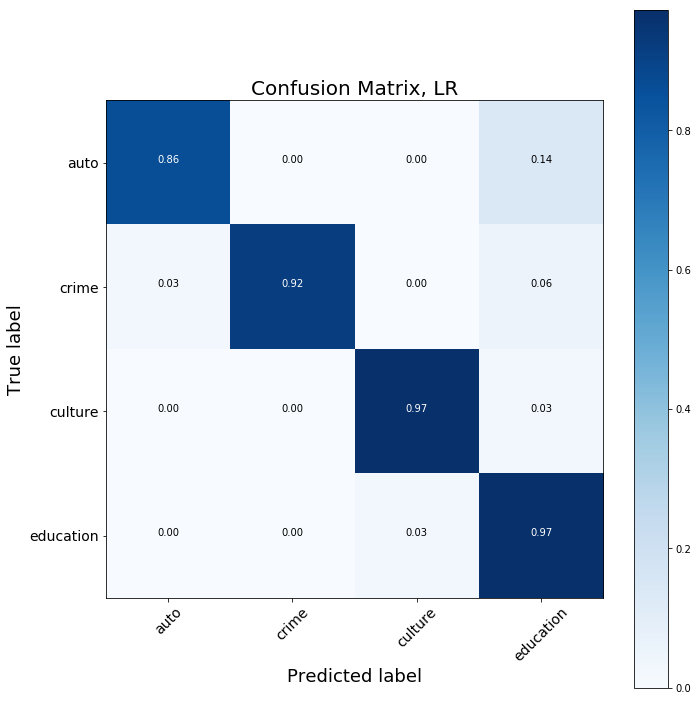

In [118]:
cmt_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cmt_lr, title='Confusion Matrix, LR')

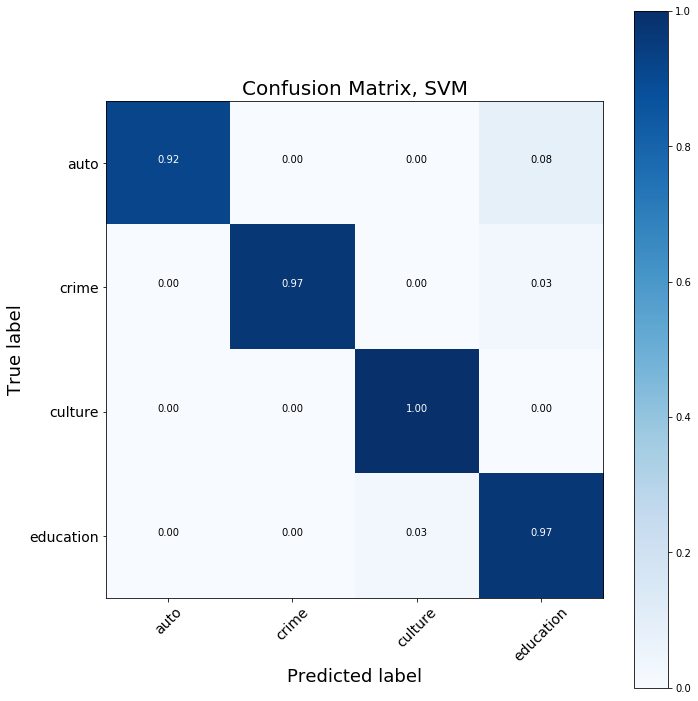

In [119]:
cmt_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cmt_svm, title='Confusion Matrix, SVM')

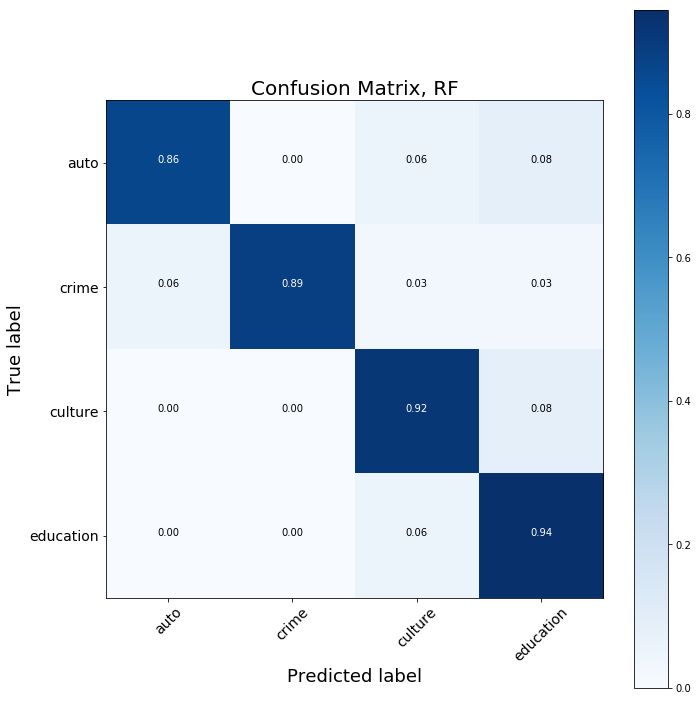

In [120]:
cmt_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cmt_rf, title='Confusion Matrix, RF')

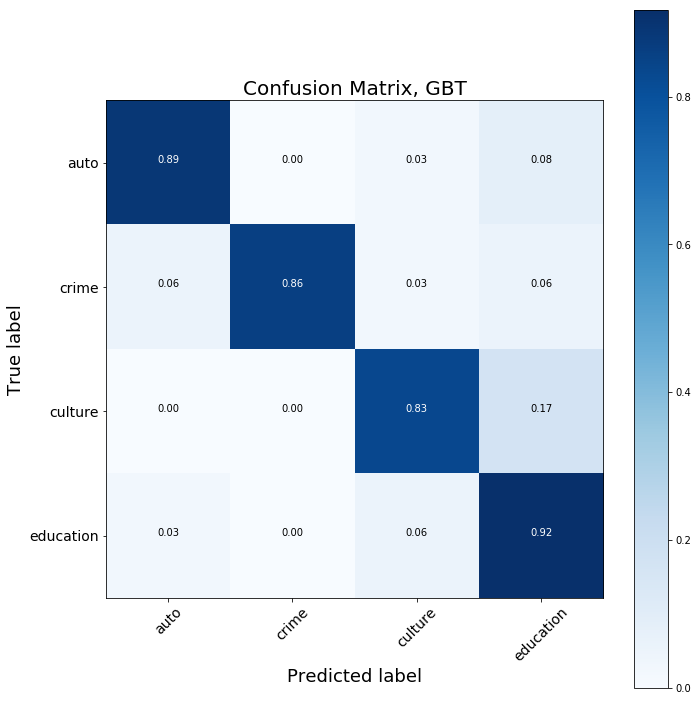

In [121]:
cmt_gbt = confusion_matrix(y_test, y_pred_gbt)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, GBT')

### Feature Importances:

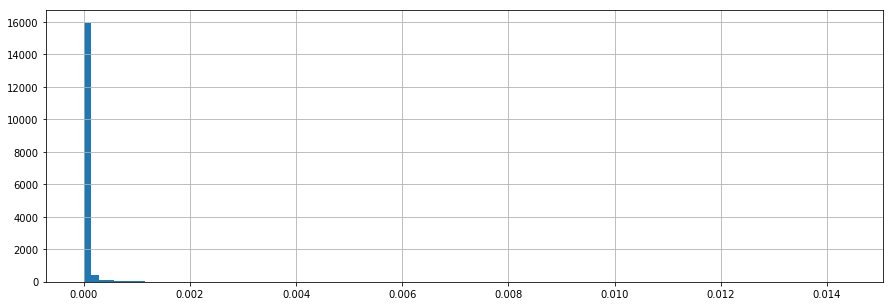

In [122]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)

(0, 0.001)

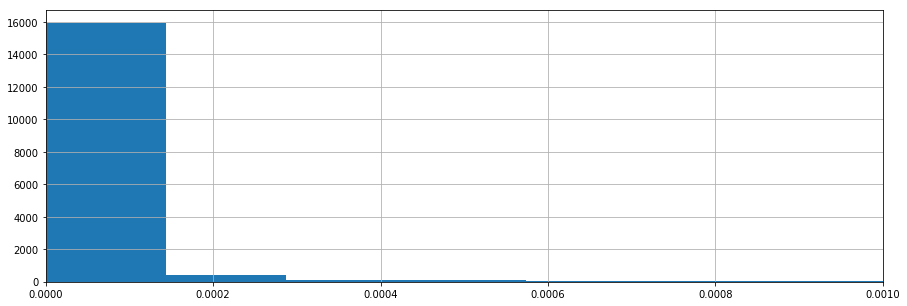

In [123]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)
plt.xlim(0, 0.001)

**Create feature selector:**

In [124]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=10)).fit(X_train, y_train)

In [126]:
X_train_transformed = feature_selector.transform(X_train)
X_test_transformed = feature_selector.transform(X_test)

print (X_train_transformed.shape, X_test_transformed.shape)

(572, 818) (144, 818)


**Train and evaluate the new classifier:**

In [127]:
predictor_lr_ = LogisticRegression().fit(X_train_transformed, y_train)

In [130]:
y_pred_lr_ = predictor_lr_.predict(X_test_transformed)
print ('LR (with feature selection) accuracy: {}'.format(round(np.mean(y_test == y_pred_lr_), 2)))

LR (with feature selection) accuracy: 0.88


### Binary Classification

In [131]:
predictor_oneVSall = OneVsRestClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [132]:
y_pred_onevsall = predictor_oneVSall.predict(X_test)
print ('One-VS-all accuracy: {}'.format(round(np.mean(y_test == y_pred_onevsall), 2)))

One-VS-all accuracy: 0.97


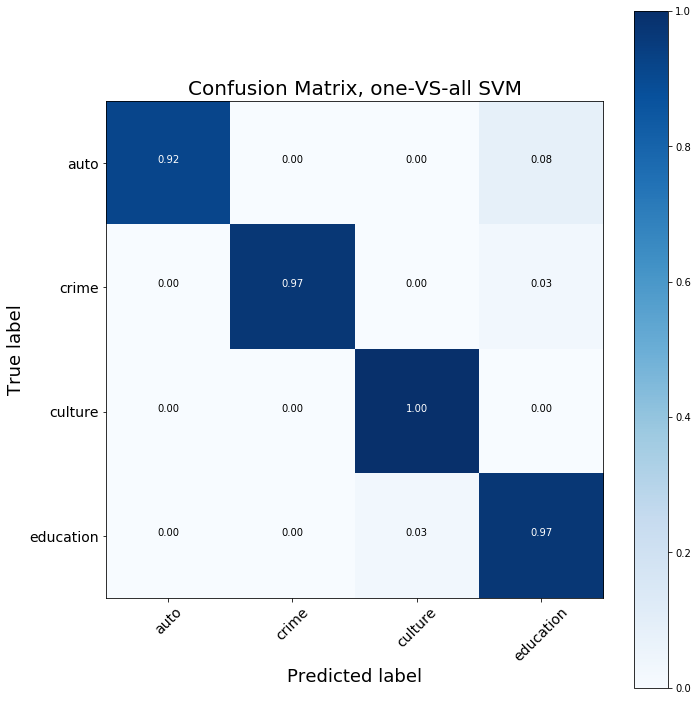

In [133]:
cmt_svm_onevsall = confusion_matrix(y_test, y_pred_onevsall)
plot_confusion_matrix(cmt_svm_onevsall, title='Confusion Matrix, one-VS-all SVM')

In [134]:
predictor_oneVSone = OneVsOneClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [135]:
y_pred_onevsone = predictor_oneVSone.predict(X_test)
print ('One-VS-one accuracy: {}'.format(round(np.mean(y_test == y_pred_onevsone), 2)))

One-VS-one accuracy: 0.94


In [200]:
y_pred_onevsone[y_pred_onevsone !=y_test]

array(['education', 'education', 'education', 'education', 'education',
       'auto', 'education', 'education', 'culture'],
      dtype='<U9')

In [204]:
pd.Series(y_pred_onevsone)!=y_test

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8       True
9      False
10     False
11      True
12     False
13     False
14     False
15      True
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28      True
29     False
       ...  
114    False
115    False
116    False
117    False
118    False
119    False
120    False
121    False
122    False
123    False
124    False
125    False
126    False
127    False
128     True
129    False
130    False
131    False
132    False
133    False
134    False
135    False
136    False
137    False
138    False
139    False
140    False
141    False
142    False
143    False
Length: 144, dtype: bool

In [206]:
print(y_pred_onevsone[8])
print(y_test[8])

education
auto


In [205]:
test_x.index = pd.RangeIndex(len(test_x))
test_x[8]

' профилактические предпраздничные мероприятия прошли во всех округах мурманска инспекторы проверяли соблюдение водителями правил перевозки детей в первые минуты рейда были выявлены нарушители один из них вез в автокресле не пристёгнутую шестилетнюю девочку в другом автомобиле полуторогодовалый ребенок сидел рядом с автокреслом на родителей составили протоколы об административном правонарушении с уплатой штрафа в размере трех тысяч рублей нежелание родителей осознавать степень опасности для детей при неиспользовании автокресел и удерживающих ремней это проблемы требующие постоянной профилактики подобная работа ведется вблизи детских садов средних образовательных учреждений медицинских организаций и центров детского досуга отмечает врио командира об дпс денис болобин '

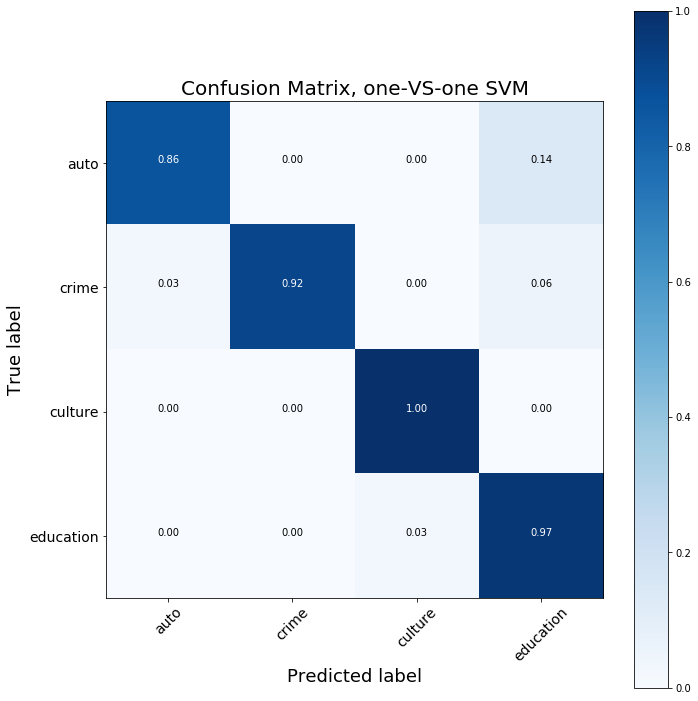

In [136]:
cmt_svm_onevsone = confusion_matrix(y_test, y_pred_onevsone)
plot_confusion_matrix(cmt_svm_onevsone, title='Confusion Matrix, one-VS-one SVM')

In [140]:
for c in np.unique(y_train):
    print ('Class \'{}\' samples N: {}'.format(c, y_train[y_train == c].shape[0]))

Class 'auto' samples N: 143
Class 'crime' samples N: 143
Class 'culture' samples N: 143
Class 'education' samples N: 143


In [158]:
X_train_bin = X_train[(y_train == 'culture') | (y_train == 'education')]
y_train_bin = y_train[(y_train == 'culture') | (y_train == 'education')]

y_train_bin[y_train_bin == 'culture'] = 0
y_train_bin[y_train_bin == 'education'] = 1
y_train_bin = y_train_bin.astype(int)

print (X_train_bin.shape, y_train_bin.shape)

(286, 16840) (286,)


In [159]:
X_test_bin = X_test[(y_test == 'culture') | (y_test == 'education')]
y_test_bin = y_test[(y_test == 'culture') | (y_test == 'education')]

y_test_bin[y_test_bin == 'culture'] = 0
y_test_bin[y_test_bin == 'education'] = 1
y_test_bin = y_test_bin.astype(int)

print (X_test_bin.shape, y_test_bin.shape)

(72, 16840) (72,)


In [167]:
one_binary_predictor = RandomForestClassifier(n_estimators=100).fit(X_train_bin, y_train_bin)

### [Metrics](https://en.wikipedia.org/wiki/Precision_and_recall)

In [168]:
y_pred_binary = one_binary_predictor.predict(X_test_bin)

print ('Binary classifiers accuracy: {}'.format(round(np.mean(y_pred_binary == y_test_bin), 2)))

Binary classifiers accuracy: 0.93


In [169]:
def FP(y_true, y_pred):
    return float(np.sum(y_true[y_true == 0] != y_pred[y_true == 0]))

In [170]:
def TP(y_true, y_pred):
    return float(np.sum(y_true[y_true == 1] == y_pred[y_true == 1]))

In [171]:
def FN(y_true, y_pred):
    return float(np.sum(y_true[y_true == 1] != y_pred[y_true == 1]))

In [172]:
def TN(y_true, y_pred):
    return float(np.sum(y_true[y_true == 0] == y_pred[y_true == 0]))

In [173]:
fp = FP(y_test_bin, y_pred_binary)
fn = FN(y_test_bin, y_pred_binary)
tp = TP(y_test_bin, y_pred_binary)
tn = TN(y_test_bin, y_pred_binary)

print ('TP = {}, FP = {}, TN = {}, FN = {}\n---------------------------------------------\nsum = {}'.format(tp, fp, tn, fn, tp + fp + tn + fn))

TP = 34.0, FP = 3.0, TN = 33.0, FN = 2.0
---------------------------------------------
sum = 72.0


In [174]:
P = precision_score(y_test_bin, y_pred_binary)
R = recall_score(y_test_bin, y_pred_binary)

print ('Precision: {}, Recall: {}'.format(P, R))

Precision: 0.918918918918919, Recall: 0.9444444444444444


In [175]:
print (tp / (tp + fp), tp / (tp + fn))

0.918918918918919 0.9444444444444444


In [176]:
print ('F1: {}'.format(f1_score(y_test_bin, y_pred_binary)))

F1: 0.9315068493150684


In [177]:
print (2.0 * P * R / (P + R))

0.931506849315


In [197]:
X_test_bin.shape

(72, 16840)

In [178]:
scores_binary = one_binary_predictor.predict_proba(X_test_bin)[:, 1]

print (scores_binary.shape)

(72,)


In [183]:
range(q * i, q * (i + 1))

range(49, 50)

In [184]:
scores_sorted[q * i : q * (i + 1)]

array([ 0.66])

In [193]:
scores_sorted

array([ 0.05,  0.11,  0.16,  0.16,  0.17,  0.18,  0.2 ,  0.22,  0.23,
        0.24,  0.25,  0.25,  0.25,  0.26,  0.26,  0.28,  0.31,  0.31,
        0.32,  0.32,  0.32,  0.33,  0.34,  0.34,  0.4 ,  0.4 ,  0.4 ,
        0.41,  0.42,  0.43,  0.44,  0.46,  0.46,  0.47,  0.48,  0.51,
        0.54,  0.55,  0.55,  0.56,  0.56,  0.57,  0.59,  0.61,  0.62,
        0.62,  0.62,  0.63,  0.64,  0.66,  0.66,  0.66,  0.68,  0.69,
        0.71,  0.71,  0.72,  0.72,  0.73,  0.74,  0.78,  0.78,  0.79,
        0.79,  0.8 ,  0.8 ,  0.82,  0.82,  0.83,  0.83,  0.84,  0.86])

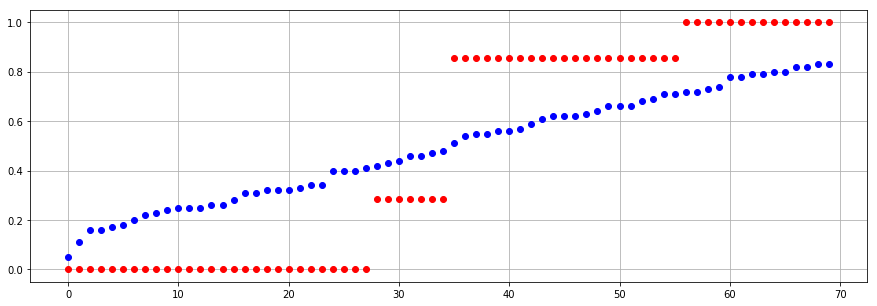

In [198]:
plt.figure(figsize=(15, 5))

N_batch = 10
inds = np.argsort(scores_binary)
scores_sorted = scores_binary[inds]
y_sorted = y_test_bin[inds]
q = len(y_test_bin) // N_batch

for i in range(N_batch):
    plt.plot(range(q * i, q * (i + 1)), scores_sorted[q * i : q * (i + 1)],'ob')
    plt.plot(range(q * i, q * (i + 1)), [np.mean(y_sorted[q * i : q * (i + 1)])] * q, 'ro')
    
plt.grid(True)

In [52]:
fpr, tpr, thresholds = roc_curve(y_test_bin, scores_binary)

(-0.1, 1.1)

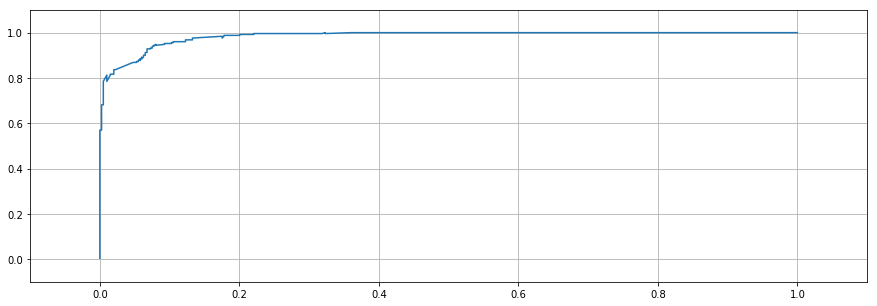

In [53]:
plt.figure(figsize=(15, 5))

inds = np.argsort(fpr)
plt.plot(fpr[inds], tpr[inds])
plt.grid(True)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

In [54]:
roc_auc = roc_auc_score(y_test_bin, scores_binary)

print 'AUC score: {}'.format(roc_auc, 2)

AUC score: 0.983794146721


In [56]:
f1_max = 0
y_pred_best = None

for thr in thresholds:
    y_pred_tuned = scores_binary.copy()
    y_pred_tuned[y_pred_tuned < thr] = 0
    y_pred_tuned[y_pred_tuned >= thr] = 1
    
    f1 = f1_score(y_test_bin, y_pred_tuned)
    if f1 > f1_max:
        f1_max = f1
        y_pred_best = y_pred_tuned
    if f1 > 0.894308943089:
        print 'thr = {}: F1 +{}'.format(thr, round(f1 - 0.8920570264765784, 4))
        
print
print 'Max. F1: {}'.format(round(f1_max, 3))

thr = 0.504785655909: F1 +0.0035
thr = 0.485095370974: F1 +0.0031
thr = 0.480729676346: F1 +0.0057
thr = 0.480516493463: F1 +0.0039
thr = 0.469977336138: F1 +0.0083
thr = 0.46990937657: F1 +0.0066
thr = 0.467158472881: F1 +0.0131
thr = 0.466458427364: F1 +0.0113
thr = 0.462352420533: F1 +0.0199
thr = 0.458340955617: F1 +0.0163
thr = 0.45658557643: F1 +0.0184
thr = 0.455257528258: F1 +0.0167
thr = 0.454569310697: F1 +0.0209
thr = 0.447121968459: F1 +0.0191
thr = 0.44270785316: F1 +0.0212
thr = 0.437210235221: F1 +0.0195
thr = 0.437015086662: F1 +0.0216
thr = 0.434122501169: F1 +0.0129
thr = 0.430693801046: F1 +0.015
thr = 0.421791120273: F1 +0.0081
thr = 0.420593583687: F1 +0.0102
thr = 0.419017649164: F1 +0.0085
thr = 0.409890690352: F1 +0.0106
thr = 0.396582332444: F1 +0.003

Max. F1: 0.914


In [57]:
print np.mean(y_test_bin == y_pred_best)

0.9307692307692308


## Ensembling

In [58]:
print np.mean(RandomForestClassifier(n_estimators=10).fit(X_train, y_train).predict(X_test) == y_test)
print np.mean(RandomForestClassifier(n_estimators=100, criterion='entropy').fit(X_train, y_train).predict(X_test) == y_test)
print np.mean(GradientBoostingClassifier(n_estimators=10).fit(X_train, y_train).predict(X_test) == y_test)

0.503755364806867
0.574928469241774
0.5160944206008584


In [59]:
ensemble_soft = VotingClassifier([('rf_gini_10', RandomForestClassifier(n_estimators=10)),
                                  ('rf_entropy_100', RandomForestClassifier(n_estimators=100, criterion='entropy')),
                                  ('gbt_100', GradientBoostingClassifier(n_estimators=10))], voting='soft', n_jobs=1)

ensemble_hard = VotingClassifier([('rf_gini_10', RandomForestClassifier(n_estimators=10)),
                                  ('rf_entropy_100', RandomForestClassifier(n_estimators=100, criterion='entropy')),
                                  ('gbt_100', GradientBoostingClassifier(n_estimators=10))], voting='hard', n_jobs=1)

In [60]:
ensemble_soft.fit(X_train, y_train)
ensemble_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('rf_gini_10', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
          ...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [61]:
y_pred_hard = ensemble_hard.predict(X_test)
y_pred_soft = ensemble_soft.predict(X_test)

print y_pred_hard.shape, y_pred_soft.shape

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(5592,) (5592,)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [62]:
print 'Hard voting accuracy: {}%'.format(round(np.mean(y_test == y_pred_hard), 2))
print 'Soft voting accuracy: {}%'.format(round(np.mean(y_test == y_pred_soft), 2))

Hard voting accuracy: 0.57%
Soft voting accuracy: 0.58%
